<a href="https://colab.research.google.com/github/bclee232/DLwP/blob/master/7_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet', 
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base.summary()

Using TensorFlow backend.


58892288/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [4]:
# mount the folder to gain access
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/gdrive/My Drive/cats_dogs_tiny'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count, conv_base):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 200, conv_base)
validation_features, validation_labels = extract_features(validation_dir, 100, conv_base)
test_features, test_labels = extract_features(test_dir, 100, conv_base)

Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [7]:
# flatten features for Dense classifier
import numpy as np

print(train_features.shape, validation_features.shape, test_features.shape)
x_train = np.reshape(train_features, (200, 4 * 4 * 512))
x_val = np.reshape(validation_features, (100, 4 * 4 * 512))
x_test = np.reshape(test_features, (100, 4 * 4 * 512))

(200, 4, 4, 512) (100, 4, 4, 512) (100, 4, 4, 512)


In [8]:
# Dense classifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers

def build_model():
  model = Sequential()
  model.add(Dense(256, activation='relu', input_dim=4*4*512))
  model.add(Dropout(0.5))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['acc'])
  return model

In [9]:
model = build_model()
hist = model.fit(x_train, train_labels, epochs=30, batch_size=20,
                 validation_data=(x_val, validation_labels))
# 90% accuracy and very fast on CPU!!
# but overfitting present near the start (so need data augmentation)

Train on 200 samples, validate on 100 samples
Epoch 1/30
200/200 [==============================] - 0s 2ms/step - loss: 0.6721 - acc: 0.6200 - val_loss: 0.4766 - val_acc: 0.7500
Epoch 2/30
200/200 [==============================] - 0s 1ms/step - loss: 0.4310 - acc: 0.8000 - val_loss: 0.3692 - val_acc: 0.8800
Epoch 3/30
200/200 [==============================] - 0s 1ms/step - loss: 0.3585 - acc: 0.8650 - val_loss: 0.3541 - val_acc: 0.8300
Epoch 4/30
200/200 [==============================] - 0s 1ms/step - loss: 0.3013 - acc: 0.8800 - val_loss: 0.3253 - val_acc: 0.8500
Epoch 5/30
200/200 [==============================] - 0s 1ms/step - loss: 0.2561 - acc: 0.8950 - val_loss: 0.3429 - val_acc: 0.8700
Epoch 6/30
200/200 [==============================] - 0s 1ms/step - loss: 0.2071 - acc: 0.9400 - val_loss: 0.3642 - val_acc: 0.8600
Epoch 7/30
200/200 [==============================] - 0s 1ms/step - loss: 0.1730 - acc: 0.9600 - val_loss: 0.2650 - val_acc: 0.9300
Epoch 8/30
200/200 [==========

In [21]:
# use data augmentation (this techinque can't run on CPU efficiently)
from keras.layers import Flatten

a_model = Sequential()
a_model.add(conv_base)
a_model.add(Flatten())
a_model.add(Dropout(0.5))
a_model.add(Dense(256, activation='relu'))
a_model.add(Dense(1, activation='sigmoid'))

# freeze the conv base so its weights cannot be updated
conv_base.trainable = False

In [11]:
# use data augmentation
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)
# validation data should not be augmented

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

valid_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

a_model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                loss='binary_crossentropy',
                metrics=['acc'])

Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [12]:
# book used 100, 3, 5
hist = a_model.fit_generator(train_generator, 
                             steps_per_epoch=10,
                             epochs=1,
                             validation_data=valid_generator,
                             validation_steps=5)

Epoch 1/1
10/10 [==============================] - 68s 7s/step - loss: 0.6988 - acc: 0.5100 - val_loss: 0.6528 - val_acc: 0.6900


In [13]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [14]:
fine_model = build_model()
fine_hist = fine_model.fit(x_train, train_labels, epochs=30, batch_size=20,
                 validation_data=(x_val, validation_labels))

Train on 200 samples, validate on 100 samples
Epoch 1/30
200/200 [==============================] - 0s 2ms/step - loss: 0.7217 - acc: 0.5950 - val_loss: 0.5155 - val_acc: 0.6900
Epoch 2/30
200/200 [==============================] - 0s 1ms/step - loss: 0.5105 - acc: 0.7450 - val_loss: 0.3826 - val_acc: 0.9000
Epoch 3/30
200/200 [==============================] - 0s 1ms/step - loss: 0.3316 - acc: 0.8600 - val_loss: 0.3399 - val_acc: 0.8800
Epoch 4/30
200/200 [==============================] - 0s 1ms/step - loss: 0.2686 - acc: 0.9300 - val_loss: 0.3563 - val_acc: 0.8300
Epoch 5/30
200/200 [==============================] - 0s 1ms/step - loss: 0.2367 - acc: 0.9200 - val_loss: 0.3955 - val_acc: 0.8300
Epoch 6/30
200/200 [==============================] - 0s 1ms/step - loss: 0.2022 - acc: 0.9500 - val_loss: 0.2750 - val_acc: 0.9000
Epoch 7/30
200/200 [==============================] - 0s 1ms/step - loss: 0.1576 - acc: 0.9550 - val_loss: 0.2703 - val_acc: 0.8900
Epoch 8/30
200/200 [==========

In [15]:
test_dir = '/content/gdrive/My Drive/cats_dogs_tiny/test'
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')
# test_loss, test_acc = fine_model.evaluate_generator(test_generator, steps=50)
# make sure to use generator for the data augmentation model
test_loss, test_acc = fine_model.evaluate(x_test,test_labels, batch_size=20)
test_loss2, test_acc2 = model.evaluate(x_test,test_labels, batch_size=20)
test_loss3, test_acc3 = a_model.evaluate_generator(test_generator, steps=5)

print('test acc:', test_acc, test_acc2, test_acc3)
# 81% on finely tuned (fast feature extraction) from only 200 trained images :o
# if using 2000 images might achieve high 90s (but need data augmentation)
# running for second time results in same acc cos not frozen correctly?

Found 100 images belonging to 2 classes.
100/100 [==============================] - 0s 185us/step
test acc: 0.7900000214576721 0.7900000214576721 0.6299999952316284


In [16]:
# preprocess single image of a dog
img_path = '/content/gdrive/My Drive/cats_dogs_tiny/test/dogs/dog.150.jpg'

from keras.preprocessing import image

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img) # 4D tensor
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


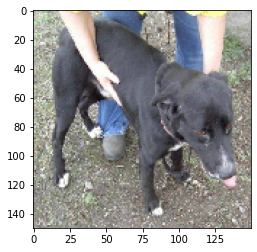

In [18]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

In [26]:
# load activation model
from keras.models import Model

a_model.summary()
# can't visualise - vgg16 should be 8 layers
# layers_outputs = [layer.output for layer in a_model.layers[:8]]
# activation_model = Model(inputs=a_model.input, outputs=layer_outputs)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
